# import libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from scipy.interpolate import Rbf
import random as rand
import pdb 
import sys
#
matplotlib.rcParams['text.usetex'] = True
warnings.filterwarnings('ignore')
#
#path = '/Users/Home/Desktop/Tmp/txt/test4th/Run0' #--- comment if passed by argument

# input stress file

In [29]:
def GetOrthogonalBasis( CellVector ): 
    a0 = CellVector[:,0]
    l0 = np.dot(a0,a0)**0.5
    n0 = a0 / l0 
    #
    a1 = CellVector[:,1]
    a1_perp = a1 - np.dot( a1, n0 ) * n0
    l1 = np.dot( a1_perp, a1_perp) ** 0.5
    #
    a2 = CellVector[:,2]
    l2 = np.dot(a2,a2)**0.5
    
    return np.c_[a0, a1_perp, a2], [l0, l1, l2]

def GetCordsTimeStep(slist):
    slist.readline()
    itime = int( slist.readline().split()[0] )
    
    [slist.readline() for i in xrange(1)]
    nrows = int(slist.readline().split()[0])

    [slist.readline() for i in xrange(1)]
    
    CellVector = np.array([slist.readline().split() for i in xrange( 3 )])
    
    cols = slist.readline().split()[2:]
    
    return np.array([slist.readline().split() for i in xrange( nrows )]), CellVector, itime, cols
    
def GetCords( file_name,
              ncount = sys.maxint):
    slist = open( file_name )    
    coord_atoms_broken = {}
    CellVector = {}
    count = 0
    try:
        while True and count <= ncount:
            sarr, cell_vector, itime, cols  = GetCordsTimeStep( slist ) #--- get coord
            #--- insert in a data frame
            coord_atoms_broken[ itime ] = pd.DataFrame( sarr, columns = cols )
            
            #--- cast id to 'int'
            coord_atoms_broken[ itime ]['id'] = map(int,coord_atoms_broken[ itime ]['id'].tolist())[:]

            #--- sort
            coord_atoms_broken[ itime ].sort_values( by = 'id', inplace = True )
            
            #--- reset index
            coord_atoms_broken[ itime ].reset_index( drop=True, inplace=True )
            
            CellVector[ itime ] = cell_vector
            
            count += 1
    except:
#        traceback.print_exc()
        pass

    
    return coord_atoms_broken, CellVector

def GetCellVector( CellVector ):
    CellVector[0] = np.c_[CellVector[0],['0.0','0.0','0.0']] #--- ref. state

    CellOrigin = {}
    cell_vector = {}
    
    for itime in CellVector:
        row0 = map( float, CellVector[ itime ][ 0 ] )
        l0 = row0[ 1 ] - row0[ 0 ] - row0[ 2 ]
        CellVector0 = np.array( [ l0, 0.0, 0.0 ] )
        dx = row0[ 2 ]
        
        row1 =  map( float, CellVector[ itime ][ 1 ] )
        l1 = row1[ 1 ] - row1[ 0 ]
        a1 = np.array( [ 0.0, l1, 0.0 ] )
        CellVector1 = CellVector0 * ( dx / l0 ) + a1
        
        row2 =  map( float, CellVector[ itime ][ 2 ] )
        l2 = row2[ 1 ] - row2[ 0 ]
        CellVector2 = np.array( [ 0.0, 0.0, l2 ] )
        
        CellOrigin[ itime ] = np.array( [ row0[ 0 ], row1[ 0 ], row2[ 0 ] ] )
        cell_vector[ itime ] = np.c_[ CellVector0, CellVector1, CellVector2 ] 

    return CellOrigin, cell_vector

 
fileName = ('virialStress.xyz','junk')[0]#--- parse cords
coord_atoms_broken, cell_vector = GetCords( '%s/%s'%(path, fileName ), ncount = sys.maxint ) #--- add xyz for broken bonds #--- check id!!1
CellOrigin, CellVector = GetCellVector( cell_vector )

# stress-strain curve

KeyError: 'c_1[4]'

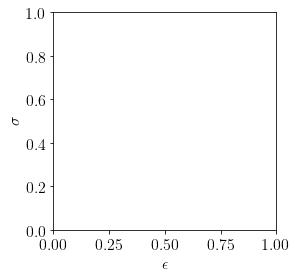

In [43]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\sigma$',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set_yscale('log')
#ax.set_ylim(1e6,1e8)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- point corresponding to strain maps
virial = []
mu = []
strain = []
times = coord_atoms_broken.keys()
times.sort()
for itime in times:
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
    volume = np.linalg.det( CellVectorOrtho )
    virial += [np.c_[coord_atoms_broken[itime]['c_1[4]']].astype(float).sum() / volume]
    mu += [np.c_[coord_atoms_broken[itime]['c_1[22]']].astype(float).sum() / volume]
    #--- strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    strain += [0.5*dx/l1]

#--- plot stress
ax.plot(2*np.array(strain),np.array(virial),'-o')

#--- fit
coeffs = np.polyfit(2*np.array(strain)[1:],np.array(virial)[1:], 1)
def func(x, m, b):
    return m*x+b


#--- print fit
ax.plot(2*np.array(strain),func(2*np.array(strain), *coeffs),'-.r')

#
plt.savefig('stressStrain.png',dpi=75,bbox_inches='tight')
plt.show()

# Born Modulus

## Bulk value

NameError: name 'coeffs' is not defined

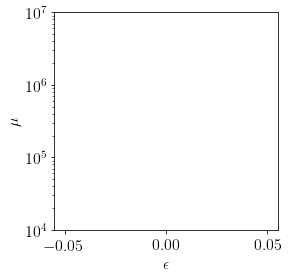

In [44]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
#ax2 = ax.twinx()
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')
ax.set_ylim(1e4,1e7)
#ax2.tick_params(labelsize=16)
#ax.set_title(fileNamee[:-4])
#
#ax.plot(stress[:,0],stress[:,1],'-')

#--- plot mu
ax.plot(2*np.array(strain),np.array(mu),'-rs', label='Born Theory')

#--- plot stress
#ax.plot(2*np.array(strain),np.array(virial),'-o')
#ax.plot(2*np.array(strain),np.gradient(virial,2*np.array(strain)),'-o')
ax.plot(ax.axis()[:2],[ coeffs[0], coeffs[0] ],'-.', label='estimate')
#
ax.legend()
#
plt.savefig('bornModulus.png',dpi=75,bbox_inches='tight')
plt.show()

## PDF

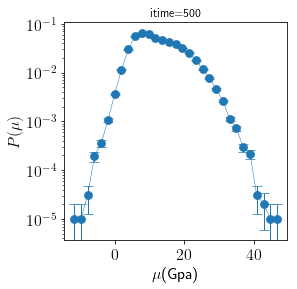

In [47]:
def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=True)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]
    
    return  hist, edges, hist / count**0.5



#--- size distribution
itime = ITIME = rand.sample(coord_atoms_broken.keys(),1)[0]
value = np.c_[coord_atoms_broken[itime]['c_1[22]']].astype(float)*1e-6
hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

#--- plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-10,1e-4)
ax.set_xlabel(r'$\mu$(Gpa)',fontsize=16)
ax.set_ylabel(r'$P(\mu)$',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title(r'itime=%s'%itime)
#
ax.errorbar(edges2,hist,error,fmt='-o',
            markersize=8,markeredgewidth=0.7,
                linewidth=.5,
                 barsabove=None,capsize=5,capthick=1,elinewidth=1)
#
plt.savefig('muPDF.png',dpi=75,bbox_inches='tight')
plt.show()

## Interpolation


### mapping & add copies

In [30]:
def ChangeBasis( coord_atoms_broken, CellVector, CellOrigin ): #, **kwargs ):
############################################################
####### map atoms within a tilted box to an orthogonal one
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    DimensionlessCords = GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin  ) #--- beta0, beta1, beta2

    #--- shift (beta0 + beta1 * dx / |b0| > 1) by - b0
    #--- [b0,b1]^{-1}*(x=|b0|,y)
    
    b2 = CellVector[:,2]
    b1 = CellVector[:,1]
    b0 = CellVector[:,0]
    norm_b0 = np.dot(b0,b0)**0.5
    shift0 = np.dot(b1, b0 / norm_b0 )
    #
    beta0 = DimensionlessCords[:,0]
    beta1 = DimensionlessCords[:,1]
    indices_shiftTrue = (beta0) + (beta1)*shift0/norm_b0 >= 1.0
    n = len( indices_shiftTrue )
    shift_matrix =  np.array(indices_shiftTrue).reshape((n,1)) * b0
    #
    xyz = coord_atoms_broken - shift_matrix
    #
    return xyz 
#
def AddCopies( coord_atoms_broken, CellVector, CellOrigin, 
               **kwargs ):    
############################################################
####### add replicals of the center simulation box
############################################################
    assert type(coord_atoms_broken) == type(pd.DataFrame())
    
    assert type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    #--- orignial cell
    XYZ_shifted = np.c_[coord_atoms_broken]
    xyz_original = XYZ_shifted.copy()
    #--- add other attributes to xyz 
    attr_list = list(coord_atoms_broken.keys()) 

#     #--- exclude xyz
    df = pd.DataFrame(kwargs)
    ID_TYPE_shifted = np.c_[df] #values[:,3:]
    id_type_original = ID_TYPE_shifted.copy()
    
    #--- cell copies
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
    #            print i,j,k
                if i == j == k == 0:
                    continue
                total_shift = np.matmul( CellVector, np.array([i,j,k]) ) #--- shape (3,)
                total_shift = np.concatenate([total_shift,total_shift],axis=0) #--- shape: (6,)
                #--- add shift
                xyz_shifted = xyz_original + total_shift
                #--- append
                XYZ_shifted = np.concatenate( ( XYZ_shifted, xyz_shifted ), axis = 0 )
                ID_TYPE_shifted = np.concatenate( ( ID_TYPE_shifted, id_type_original ), axis = 0 )
                                
    return pd.DataFrame(np.c_[XYZ_shifted,ID_TYPE_shifted],columns=attr_list + list(df.keys()))
#
def GetDimensionlessCords( CellVector, coord_atoms_broken, CellOrigin): #, **kwargs  ):
############################################################
####### compute dimensionless coords of atoms given 
####### corresponding cartesian coords
############################################################
    assert type(coord_atoms_broken) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    xyz_centered = coord_atoms_broken - CellOrigin
    beta = np.matmul( np.linalg.inv(CellVector), xyz_centered.T).T
    
        
    return beta 

def shiftBeta( xyzDimensionless_j, diff ):
    indices = diff > 0.5
    beta0_j = xyzDimensionless_j - 1.0 * indices

    indices = diff < -0.5
    beta0_j += 1.0 * indices
    
    return beta0_j
#
def GetXYZ( CellVector, CellOrigin, DimensionlessCords ): #, attr_list = ['x','y','z'], **kwargs ):
############################################################
####### compute coords of atoms given 
####### corresponding dimensionless coords
############################################################
    assert type(DimensionlessCords) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    XYZ_centered = np.matmul( CellVector, DimensionlessCords.T ).T #--- xyz in reference state
    XYZ = XYZ_centered + CellOrigin
    
        
    return XYZ 
#
def MapCoord( coord_atoms_broken,
              KEYS,
              **kwargs
            ):
############################################################
##### map coords and add images of atoms and 
##### relevant attributes
############################################################
    coord = {}
    for itime in KEYS:
        #--- map atoms in the ref. state to an undeformed box
        df = coord_atoms_broken[ itime ]
        xyz = np.c_[df[['x','y','z']].astype('float')]
        xyz_mapped = ChangeBasis( xyz, CellVector[ itime ], CellOrigin[ itime ] )

        #--- append ['xm','ym','zm']
        #--- column list
        AddColumns = ['xm','ym','zm'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        
        columns = list(df.keys())+ AddColumns
        coord[itime] = pd.DataFrame(np.c_[df, xyz_mapped],columns=columns)


    return coord 
#    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict
#
def GetCopies( coord_atoms_broken,
               CellVector,
               CellOrigin,
               KEYS,
               ev = 0.1,
               columns_r = ['x','y','z'],
               columns_rm = ['xm','ym','zm'] #--- transform these coulmns
             ):
############################################################
####### add replicals of the center simulation box
############################################################
    
    columns = columns_r + columns_rm
    for itime in KEYS:
        df = coord_atoms_broken[ itime ].copy()
        #
        xyz = np.c_[df[columns].astype('float')] #--- store 'xyz','xm'
        #--- store other columns in a dict. and pass as a kwrd arg.
        for item in columns: #--- pop 'xyz'
            df.pop( item )
        sdict = to_dict(df) #--- store in a dic. 
        #---
        xyz_copy = AddCopies( pd.DataFrame(xyz, columns=columns), CellVector[ itime ], CellOrigin[itime],
                              **sdict
                            )
        #--- print mapped xyz
#         PrintOvito( xyz_copy, 
#                     open( 'xyz_copy.xyz','w'), 
#                     footer = 'ITIME=%s'%itime,
#                     attr_list=['id','type','xm','ym','zm'] )

        #--- exclude atoms in the replicas which are out of the expanded box
        indices =  isInsideExpanded( CellOrigin[ itime ], 
                                   CellVector[ itime ],
                                   np.c_[xyz_copy[columns_rm]], #--- give mapped coordinates
                                   ev = ev,
                                 )
        coord_atoms_broken[itime] = xyz_copy[ indices ]

def isInsideExpanded( CellOrigin, CellVector, xyz, ev = 0.2):
############################################################
####### Get atoms inside an expanded box
############################################################    
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

#
#--- tensor associated with dilation
    strainTensor = np.array([[ev/3.0,0,0],
                            [0,ev/3.0,0],
                            [0,0,ev/3.0]])
    #
    identityMat = np.array([[1,0,0],[0,1,0],[0,0,1]])
    #
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )

    #--- extend diagonal
    rvect = -np.matmul( CellVectorOrtho, np.array([0.5,0.5,0.5]))
    CellOrigin_expanded = CellOrigin + np.matmul(strainTensor,rvect)

    #--- extend basis vectors
    CellVector_expanded = np.matmul( identityMat + strainTensor, CellVectorOrtho )

    return isInside( CellOrigin_expanded, CellVector_expanded, 
                     xyz )


def isInside( CellOrigin, CellVector, xyz ):
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    DimensionlessCords = GetDimensionlessCords( CellVector, 
                                                xyz,
                                                CellOrigin,
                                              )
    #--- filter: only inside the expanded box 
    beta0 = DimensionlessCords[:,0]
    beta1 = DimensionlessCords[:,1]
    beta2 = DimensionlessCords[:,2]
    index0 = np.all([beta0 >= 0.0, beta0 < 1.0], axis=0 )
    index1 = np.all([beta1 >= 0.0, beta1 < 1.0], axis=0 )
    index2 = np.all([beta2 >= 0.0, beta2 < 1.0], axis=0 )
    
    return np.all([index0,index1,index2],axis=0)   



def EstimateUnwrappedCord( coord_atoms_broken_i, coord_atoms_broken_j,
                           CellVector_i, CellVector_j,
                           CellOrigin_i, CellOrigin_j):
    
    assert type(coord_atoms_broken_i) == type( coord_atoms_broken_j ) ==\
           type( CellVector_i ) == type( CellVector_j ) ==\
           type( CellOrigin_i ) == type( CellOrigin_j ) == type(np.array([]))

    
    #--- dimensionless cords
    xyzDimensionless_i = GetDimensionlessCords( CellVector_i, coord_atoms_broken_i, CellOrigin_i )
    xyzDimensionless_j = GetDimensionlessCords( CellVector_j, coord_atoms_broken_j, CellOrigin_j )

    #--- shift to get unwrapped cords
    diff = xyzDimensionless_j - xyzDimensionless_i

    #--- new dimensionless cords
    beta0_j = shiftBeta( xyzDimensionless_j[:,0], diff[:,0])
    beta1_j = shiftBeta( xyzDimensionless_j[:,1], diff[:,1])
    beta2_j = shiftBeta( xyzDimensionless_j[:,2], diff[:,2])

    #--- unwrapped cords at deformed state
    rj_unwrpd = GetXYZ( CellVector_j, CellOrigin_j, np.c_[beta0_j,beta1_j,beta2_j] )

    return rj_unwrpd

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print 'column already included!'
        return False
    return True
    
    
def GetDipl( coord,
        CellVector, CellOrigin,
        KEYS = [0],
        REF = 'initial', #'previous'
        **kwargs
        ):
#    REF = ('initial', 'previous')[1] #--- displ. with respect to an initial state or previous state

    times = KEYS #coord_atoms_broken.keys()
    times.sort()
    for time_i, time_j in zip(times[:-1], times[1:]):   
        if REF == 'initial':
            time_i = 0
    #    print time_i, time_j
        #--- estimate unwrapped coordinates (deformed state)
        # r^{wrpd}_i, r^{wrpd}_j, r^{unwrpd}_j
        xyz_i = np.c_[coord[time_i][['x','y','z']]].astype('float')
        xyz_j = np.c_[coord[time_j][['x','y','z']]].astype('float')
        rj_unwrpd = EstimateUnwrappedCord( xyz_i, xyz_j,
                                           CellVector[time_i], CellVector[time_j],
                                           CellOrigin[time_i], CellOrigin[time_j] )    
        #--- displacement: r^{unwrpd}_j - r^{wrpd}_i
        disp = rj_unwrpd - xyz_i
        
        #--- append (xm,ym,zm) denoting mapped coordinates
        df = coord[ time_j ]
        
        #--- column list
        AddColumns = ['ux','uy','uz'] if  not 'AddColumns' in kwargs else kwargs['AddColumns']
        if not isSane( AddColumns, df.keys() ):
            return
        #--- append
        columns = list(df.keys()) + AddColumns
        
        ikey = time_j if REF == 'initial' else time_i
        coord[ ikey ] = pd.DataFrame(np.c_[df, disp],columns = columns )

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def Wrap( CellOrigin, CellVector, xyz ):
############################################################
####### Wrap atom positions 
############################################################    
    assert type(xyz) == type( CellVector ) == type( CellOrigin )\
           == type(np.array([]))

    
    DimensionlessCords = GetDimensionlessCords( CellVector, 
                                                xyz,
                                                CellOrigin,
                                              )
    
    DimensionlessCords = DimensionlessCords % 1.0
    
    XYZ = GetXYZ( CellVector, CellOrigin, DimensionlessCords )
    
    indices = isInside( CellOrigin, CellVector, XYZ )
    
    assert len( XYZ[ indices ] ) == len( XYZ ), 'not all atoms are inside!'
    
    return XYZ



def WrapDataFrame( coord_atoms_broken, 
                   CellOrigin, CellVector,
                   KEYS,
                   columns = ['x','y','z']):
    
    for itime in KEYS:
        df = coord_atoms_broken[ itime ].copy()
        xyz = np.c_[df[columns]].astype(float)
        xyz_wrapped = Wrap(CellOrigin[ itime ], CellVector[ itime ], xyz)
        #--- replace associated columns
        for item in columns:
            df.pop( item )
        columns2 = list(df.keys())+columns
        coord_atoms_broken[ itime ] = pd.DataFrame(np.c_[df,xyz_wrapped],columns = columns2 )
        


#ITIME = 6800
#--- wrap coordintaes (don't trust lammps!)
WrapDataFrame(coord_atoms_broken, 
              CellOrigin, CellVector,
              KEYS = coord_atoms_broken.keys(), #[ITIME],
              columns = ['x','y','z']
              )

#--- compute displacements: add columns = ['ux','uy','uz']
GetDipl( coord_atoms_broken,
         CellVector, CellOrigin,
         KEYS = coord_atoms_broken.keys(),
         REF = 'initial', #'previous'
         AddColumns = ['ux','uy','uz']
       )        

#--- print actual xyz
# PrintOvito( coord_atoms_broken[ ITIME ], 
#             open( 'xyz_actual.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','x','y','z'] )

#--- map to the squared cell    : add columns = ['xm','ym','zm']
coord = MapCoord( coord_atoms_broken,
                  KEYS = coord_atoms_broken.keys(),
                  AddColumns = ['xm','ym','zm']
                )

#--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_mapped.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm'] )

#--- add replicas
GetCopies( coord,
           CellVector,
           CellOrigin,
           KEYS = coord.keys(), #[ITIME]
           ev = 0.4,
           columns_r = ['x','y','z'],
           columns_rm = ['xm','ym','zm'] #--- transform these coulmns
         )

#--- print mapped xyz
# PrintOvito( coord[ ITIME ], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%ITIME,
#             attr_list=['id','type','xm','ym','zm'] )



### cubic grid

In [31]:
def GetCubicGrid( CellOrigin, CellVector, dmean, margin  ):

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    
    volume = np.linalg.det( CellVectorOrtho )


    [nx, ny, nz] = map( int, (np.array(VectorNorm)+2*margin) / dmean )
    if nx%2 == 0:
        nx += 1
    if ny%2 == 0:
        ny += 1
    if nz%2 == 0:
        nz += 1
    
    x = np.linspace( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin, nx,endpoint=False)
    y = np.linspace( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin, ny,endpoint=False)
    z = np.linspace( CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin, nz,endpoint=False)

    return (x, y, z), np.meshgrid(x, y,z)



#--- mean dist between atoms 
natoms = len( coord_atoms_broken[ 0 ] ) 
CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ 0 ] )
volume = np.linalg.det( CellVectorOrtho )
dmean = ( volume / natoms ) ** (1.0/3.0)
print 'dmean=%s'%dmean

#--- grid tiling mapped box with original size
#--- values are interpolated onto this grid
(xlin, ylin, zlin), (xv, yv, zv) = GetCubicGrid( CellOrigin[ 0 ], 
                                                 CellVector[ 0 ], 
                                                 dmean,
                                                 margin = 0.0 * dmean )
xi = np.array(zip(xv.flatten(), yv.flatten(), zv.flatten()))
print xlin.shape, ylin.shape, zlin.shape

dmean=2.287993253406484
(35,) (39,) (39,)


### center box + margin

In [32]:
def isKeyInDataFrame(values_column, df):
    trueFalse = [key in df.keys() for key in values_column]
    return np.all(trueFalse)

def Intrp( coord,
           grid,
           keys = [ 0 ],
           points_column = ['x','y','z'],
           values_column = ['x']
         ):
    #--- linear interpolation
    df_intrp = {}
    for time_i in keys:
        #--- get a chunck of full copies
        df = coord[ time_i ]
        
        #--- assert columns are included in the df
        if not( isKeyInDataFrame(values_column, df) and isKeyInDataFrame(points_column, df) ):
            continue
        
        #--- interpolate
        points = df[ points_column ]
        values = df[ values_column ]
        xi = grid
        grid_z = scp_int.griddata(points, values, xi, method='linear')
        assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'


    #     x, y, z, d = np.c_[pointsValues[['xm','ym','zm','mu']].iloc[:-1]].T
    #     rbfi = Rbf(x.tolist(), y.tolist(), z.tolist(), d.tolist(), function = 'gaussian', epsilon = dmean)  # radial basis function interpolator instance
    #     grid_z = rbfi(xv, yv, zv).flatten()   # interpolated values

        #--- store in dataframe
        df_intrp[ time_i ] = pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z']+values_column)
    return df_intrp


#ITIME = 6700
df_intrp = Intrp( coord,
                 xi,
                 keys = coord.keys(), #[ITIME], #
                points_column = ['xm','ym','zm'],
                values_column = ['c_1[22]', 'ux', 'uy', 'uz']
               )

### Strain tensor

In [33]:
def GetStrain( value, (xlin,ylin,zlin), (xv,yv,zv)):
    #--- reshape matrix
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    ux = value[:,0].reshape((ny,nx,nz))
    uy = value[:,1].reshape((ny,nx,nz))
    uz = value[:,2].reshape((ny,nx,nz))

    #--- gradient
    ux_x = np.gradient(ux,xlin,axis=1)
    ux_y = np.gradient(ux,ylin,axis=0)
    ux_z = np.gradient(ux,zlin,axis=2)

    uy_x = np.gradient(uy,xlin,axis=1)
    uy_y = np.gradient(uy,ylin,axis=0)
    uy_z = np.gradient(uy,zlin,axis=2)

    uz_x = np.gradient(uz,xlin,axis=1)
    uz_y = np.gradient(uz,ylin,axis=0)
    uz_z = np.gradient(uz,zlin,axis=2)

    #--- strain
    exx = ux_x
    exy = 0.5 * ( ux_y + uy_x )
    exz = 0.5 * ( ux_z + uz_x )

    eyx = exy
    eyy = uy_y
    eyz = 0.5 * ( uy_z + uz_y )

    ezx = exz
    ezy = eyz
    ezz = uz_z
    
    #--- subtract mean
    exx -= np.mean(exx)
    exy -= np.mean(exy)
    exz -= np.mean(exz)

    eyx -= np.mean(eyx)
    eyy -= np.mean(eyy)
    eyz -= np.mean(eyz)

    ezx -= np.mean(ezx)
    ezy -= np.mean(ezy)
    ezz -= np.mean(ezz)
    
    return np.c_[
                 exx.flatten(), eyy.flatten(), ezz.flatten(), 
                 exy.flatten(), eyz.flatten(), ezx.flatten()]

#     return pd.DataFrame(np.c_[xv.flatten(),yv.flatten(),zv.flatten(),
#                  exx.flatten(), eyy.flatten(), ezz.flatten(), 
#                  exy.flatten(), eyz.flatten(), ezx.flatten()], 
#                  columns = ['x','y','z','exx','eyy','ezz','exy','eyz','ezx'])



for itime in df_intrp:
    df = df_intrp[ itime ]
    #
    Strain = GetStrain(np.c_[df[['ux','uy','uz']]], 
                              (xlin,ylin,zlin), (xv,yv,zv))
    #--- append to data frame
    AddColumns = ['exx','eyy','ezz','exy','eyz','ezx']
    if isSane( AddColumns, df.keys() ):
        df_intrp[ itime ] = pd.DataFrame(np.c_[df,Strain], 
                                         columns = list(df.keys())+ AddColumns
                                        )
    #--- change column name
    df_intrp[ itime ].rename(index=str, columns={"c_1[22]": "mu"}, inplace=True)


### Print

In [52]:
file_name = 'strain.xyz'
try:
    os.system('rm %s'%file_name)
except:
    pass
    
times = df_intrp.keys()
times.sort()
for itime in times:
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1

    
    PrintOvito( df_intrp[ itime ], 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','mu', 'exy'] ) #'exx','eyy','ezz','exy','eyz','ezx'] )
    

### imshow

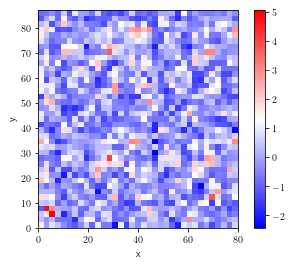

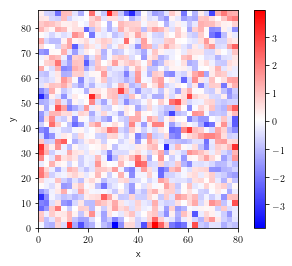

In [48]:
def FilterMatrix( CellVector, CellOrigin,
                  (xlin, ylin, zlin),
                  (xv, yv, zv ),
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[ a[i,j] for j in xrange(-(ngrid/2),ngrid/2+ngrid%2)] 
                              for i in xrange(-(mgrid/2),mgrid/2+mgrid%2)])

def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'fig.png',
             ):
        
    val = value.copy()
    #--- z-score
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
#    plt.xlim(center[0]-(ngrid/2)*frac,center[0]+(ngrid/2)*frac)
#    plt.ylim(center[1]-(mgrid/2)*frac,center[1]+(mgrid/2)*frac)
#    plt.xlim(xlim[0]*frac,xlim[1]*frac)
#    plt.ylim(ylim[0]*frac,ylim[1]*frac)
    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(title,dpi=75,bbox_inches='tight')
    plt.show()


itime = ITIME
for col in ['mu', 'exy']:

    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[df_intrp[itime][col]].reshape(((ny,nx,nz)))

    #--- filter value
    # value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = col,
            )

### Correlations

#### scatter plot (mu-exy)

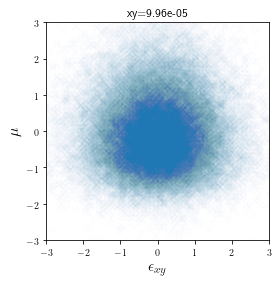

In [50]:
def zscore( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )
    return value

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon_{xy}$',fontsize=16)
ax.set_ylabel(r'$\mu$',fontsize=16)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
#
x = zscore(np.array(df_intrp[ITIME]['exy'].to_list()))
y = zscore(np.array(df_intrp[ITIME]['mu'].to_list()))
ax.scatter(x,y,marker='x',color='C0',alpha=0.01)
#
ax.set_title('xy=%3.2e'%(np.sum(x*y)/len(x)))
#
plt.savefig('mu_exy_crltn.png',dpi=75,bbox_inches='tight')
plt.show()

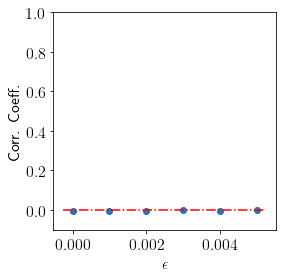

In [42]:
fig = plt.figure( figsize = (4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
ax.set_ylabel(r'Corr. Coeff.',fontsize=16)
ax.tick_params(labelsize=16)
ax.set_ylim(-0.1,1.0)
#
for itime in df_intrp:
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] )
    #--- strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    strain = 0.5*dx/l1                
    #
    x = zscore(np.array(df_intrp[itime]['exy'].to_list()))
    y = zscore(np.array(df_intrp[itime]['mu'].to_list()))
    crltn = np.sum(x*y)/len(x)
    #
    ax.plot([2*strain],[crltn], '-o',color='C0')

ax.plot(ax.axis()[:2],[0,0], '-.r',color='red')

plt.savefig('crltn_strain.png',dpi=75,bbox_inches='tight')
plt.show()

In [323]:
# def GetAutoCorrelation( val ):
#     value  = val.copy()
#     value -= np.mean( value )
#     value /= np.std( value )

#     ( nx, ny, nz ) =  value.shape
#     n = nx * ny * nz
#     vq = np.fft.fftn(value) #, axes=(0,1,2))
#     vq_sq = np.abs(vq)**2

#     v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
#     return v_real


# Crltn = {}
# for itime in mu_born:
#     #
#     (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
#     #
#     value = np.c_[mu_born[itime]['mu']].reshape(((ny,nx,nz)))
#     #
#     #--- filter value
# #     value = FilterMatrix( CellVector[0], CellOrigin[0],
# #                   (xlin, ylin, zlin),
# #                   (xv, yv, zv ),
# #                    value )

#     Crltn[ itime ] = GetAutoCorrelation( value )


In [325]:
def GetAutoCorrelation2d( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny ) =  value.shape
    n = nx * ny
    vq = np.fft.fft2(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifft2( vq_sq) / n #,  axes=(0,1,2) )
    return v_real



val = value[:,:,nz/2].copy()
Crltn = GetAutoCorrelation2d( val )


(0, 17) 0.2563218405143886


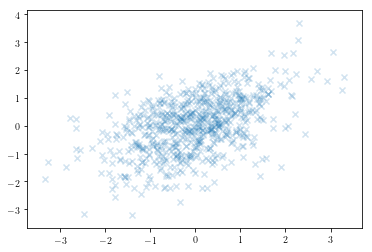

In [327]:
(m,n) = val.shape

rx=n/2
ry=0

value  = val.copy()
value -= np.mean( value )
value /= np.std( value )
    
xsum = 0.0
for i in xrange(m):
    for j in xrange(n):
        if (i+ry) >= m or (j+rx) >= n:
            continue
        xsum += value[i,j]*value[(i+ry),(j+rx)]
        plt.scatter([value[i,j].real],[value[(i+ry)%m,(j+rx)%n].real],marker='x',color='C0',alpha=0.2)
print (ry,rx), xsum / (m*n)

plt.show()

#### Print

In [307]:

# def PltCrltn( value,
#               xlabel = 'x', ylabel = 'y',
#               xlim = (-0.5,0.5), ylim = (-0.5,0.5),
#               frac = 1.0, #--- plot a patch
#               zscore = True,
#               fileName = 'cxy.png',
#               dpi=75,
#             ):
        
#     val = value.copy()
#     #--- zscore
#     if zscore:
#         val -= np.mean(val)
#         val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
#     #
#     (mgrid,ngrid) = val.shape
#     center = (ngrid/2,mgrid/2)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
#                      extent=(xlim[0],xlim[1],ylim[0],ylim[1])) #,vmin=-.01, vmax=.01)
#     plt.xlim(xlim[0]*frac,xlim[1]*frac)
#     plt.ylim(ylim[0]*frac,ylim[1]*frac)

#     plt.colorbar( pos, fraction = 0.04)
#     plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
#     plt.show()


# for itime in Crltn:
#     print 'itime=',itime
#     CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
#     #    
#     crltn = Crltn[ itime ]
#     #--- xy plane
#     val = crltn[:,:,0].copy()
#     PltCrltn( val, 
#               xlabel = 'x', ylabel = 'y',
#               xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#               frac = 1, #--- plot a patch
#               zscore = False,
#               fileName = 'cxy.%s.png'%itime,
#               dpi = 60
#             )
#     # #--- zx plane
#     # val = crltn[0,:,:].copy()
#     # PltCrltn( val, 
#     #           xlabel = 'z', ylabel = 'x',
#     #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
#     #           frac = 1.0, #--- plot a patch
#     #           zscore = False,
#     #         )
#     # #--- zy plane
#     # val = crltn[:,0,:a].copy()
#     # PltCrltn( val, 
#     #           xlabel = 'z', ylabel = 'y',
#     #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#     #           frac = 1.0, #--- plot a patch
#     #           zscore = False,
#     #         )



itime= 0


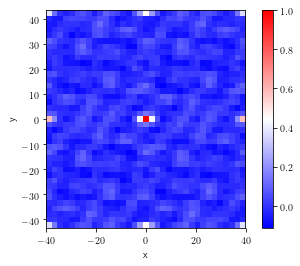

In [319]:

def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
        
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
#         val[val>2.0]=1.0
#         val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    pos = plt.imshow((CenterMatrix( val ).real),cmap='bwr',
#    pos = plt.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]))
    plt.xlim(xlim[0]*frac,xlim[1]*frac)
    plt.ylim(ylim[0]*frac,ylim[1]*frac)

    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()


    
for itime in [0]:
    print 'itime=',itime
    CellVectorOrtho, VectorNorm = GetOrthogonalBasis( CellVector[ itime ] ) #--- box length
    #    
    crltn = Crltn
    #--- xy plane
    val = crltn
    PltCrltn( val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1, #--- plot a patch
              zscore = False,
              fileName = 'cxy.%s.png'%itime,
              dpi = 60
            )
    # #--- zx plane
    # val = crltn[0,:,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'x',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )
    # #--- zy plane
    # val = crltn[:,0,:].copy()
    # PltCrltn( val, 
    #           xlabel = 'z', ylabel = 'y',
    #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
    #           frac = 1.0, #--- plot a patch
    #           zscore = False,
    #         )



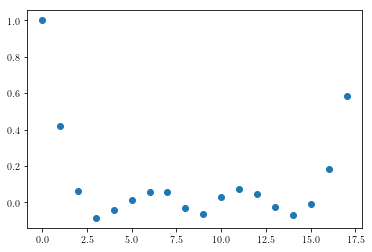

In [320]:
plt.plot(val[0,0:n/2+1],'o')
plt.show()

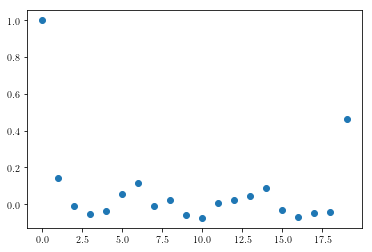

In [321]:
plt.plot(val[0:m/2+1,0],'o')
plt.show()

#### Crltn Length

In [70]:
def Get_rc( xdata, ydata, cTOL ):
    try:
        xc1 = xdata[np.abs(ydata)<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 (xv,yv),
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    xdata = np.arange(0,(n/2+n%2)) * dx
    ydata = val[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-o',label=r'$x$')       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    xdata = np.arange(0,(m/2+m%2)) * dy
    ydata = val[0:(m/2+m%2),0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,'-s', color = 'red',label=r'$y$')
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot((rc,rc),ax.axis()[2:],'-.r')
        #
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return (xc, yc)
    
    

for itime in Crltn:
    print 'itime=',itime
    #--- bulk strain
    dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
    l1=CellVector[ itime ][1,1]
    ebulk = 0.5*dx/l1
    #---
    xc, yc = PltCrltnFunc( Crltn[ itime ], 
                 (xv,yv),
                 fileName = 'cr.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    print xc, yc

itime= [ 1.        +0.00000000e+00j  0.2658274 +6.88618955e-18j
 -0.04848971-1.71179449e-17j -0.01102252-2.93916243e-17j
 -0.00884968-1.62750514e-17j  0.00918445-2.15780525e-17j
 -0.03312712-9.97251839e-18j -0.05288246-2.03756448e-17j
  0.00139661-1.38082397e-17j  0.01228676-1.68636758e-18j
 -0.03872604+8.73879645e-18j -0.06374491+1.27488594e-17j
 -0.06287136+1.78505217e-17j -0.07180323+1.72273930e-17j
 -0.0330112 +1.26224898e-17j -0.04694569+1.20088551e-17j
 -0.0283897 +9.51409139e-18j  0.38274144-1.22170903e-17j
  0.38274144+1.63072120e-17j -0.0283897 -1.87136875e-17j
 -0.04694569-1.20088551e-17j -0.0330112 -1.24391663e-17j
 -0.07180323-1.89805432e-17j -0.06287136-2.67810349e-17j
 -0.06374491-3.35037378e-18j -0.03872604-8.73879645e-18j
  0.01228676-1.12526459e-17j  0.00139661+2.79229491e-17j
 -0.05288246+1.96805331e-17j -0.03312712+1.81927031e-17j
  0.00918445+2.15780525e-17j -0.00884968+1.95271553e-17j
 -0.01102252+2.40585852e-17j -0.04848971+2.77042212e-17j
  0.2658274 -1.24691659e

TypeError: unhashable type: 'numpy.ndarray'

In [72]:
mean = coord_atoms_broken[itime]['c_1[22]'].astype(float).mean()
std = coord_atoms_broken[itime]['c_1[22]'].astype(float).std()
'%e'%(mean-2*std)

'-5.744436e+09'